In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels = os.listdir(r'/content/drive/MyDrive/dataset/train')
dataset_path=r'/content/drive/MyDrive/dataset/'
print(labels)

['Deceptive', 'Truthful']


In [ ]:
rooms=[]
for item in labels:
    all_rooms=os.listdir(dataset_path+'train'+'/'+item)
    for room in all_rooms:
        rooms.append((dataset_path+'train'+'/'+item+'/'+room,item))
random.shuffle(rooms)
train_df=pd.DataFrame(data=rooms,columns=['video_path','tag'])
print(train_df.head())
print(train_df.tail())


                                          video_path        tag
0  /content/drive/MyDrive/dataset/train/Truthful/...   Truthful
1  /content/drive/MyDrive/dataset/train/Deceptive...  Deceptive
2  /content/drive/MyDrive/dataset/train/Deceptive...  Deceptive
3  /content/drive/MyDrive/dataset/train/Truthful/...   Truthful
4  /content/drive/MyDrive/dataset/train/Truthful/...   Truthful
                                            video_path        tag
213  /content/drive/MyDrive/dataset/train/Deceptive...  Deceptive
214  /content/drive/MyDrive/dataset/train/Truthful/...   Truthful
215  /content/drive/MyDrive/dataset/train/Deceptive...  Deceptive
216  /content/drive/MyDrive/dataset/train/Deceptive...  Deceptive
217  /content/drive/MyDrive/dataset/train/Deceptive...  Deceptive


In [ ]:
#train_df.to_csv(dataset_path+'train.csv')

In [ ]:
rooms=[]
for item in labels:
    all_rooms=os.listdir(dataset_path+'test'+'/'+item)
    for room in all_rooms:
        rooms.append((dataset_path+'test'+'/'+item+'/'+room,item))
random.shuffle(rooms)
test_df=pd.DataFrame(data=rooms,columns=['video_path','tag'])
print(test_df.head())
print(test_df.tail())
#test_df.to_csv(dataset_path+'test.csv')

                                          video_path        tag
0  /content/drive/MyDrive/dataset/test/Deceptive/...  Deceptive
1  /content/drive/MyDrive/dataset/test/Truthful/t...   Truthful
2  /content/drive/MyDrive/dataset/test/Deceptive/...  Deceptive
3  /content/drive/MyDrive/dataset/test/Truthful/t...   Truthful
4  /content/drive/MyDrive/dataset/test/Deceptive/...  Deceptive
                                           video_path        tag
15  /content/drive/MyDrive/dataset/test/Truthful/t...   Truthful
16  /content/drive/MyDrive/dataset/test/Deceptive/...  Deceptive
17  /content/drive/MyDrive/dataset/test/Truthful/t...   Truthful
18  /content/drive/MyDrive/dataset/test/Deceptive/...  Deceptive
19  /content/drive/MyDrive/dataset/test/Deceptive/...  Deceptive


In [ ]:
#!conda install git
#!pip3 install -q git+https://github.com/tensorflow/docs


^C


  ERROR: Error [WinError 2] Le fichier spécifié est introuvable while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2

In [ ]:
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 218
Total videos for testing: 20


In [ ]:
IMG_SIZE = 224
def load_video(path,resize=(IMG_SIZE,IMG_SIZE )):
    cap=cv2.VideoCapture(path)
    frames=[]
    try:
        while True:
            ret,frame=cap.read()
            if not ret:
                break
            frame=cv2.resize(frame,resize)
            frames.append(frame)
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
def build_feature_extractor():
    feature_extractor=keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(IMG_SIZE,IMG_SIZE,3))
    preprocess_input=keras.applications.inception_v3.preprocess_input
    inputs=keras.Input((IMG_SIZE,IMG_SIZE,3))
    preprocessed=preprocess_input(inputs)
    outputs=feature_extractor(preprocessed)
    return keras.Model(inputs,outputs,name="feature_extractor")
feature_extractor=build_feature_extractor()

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
print(label_processor.get_vocabulary())

labels = train_df["tag"].values
labels = label_processor(labels[..., None]).numpy()


['Deceptive', 'Truthful']


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_path"].values.tolist()
    ##take all classlabels from train_df column named 'tag' and store in labels.
    labels = df["tag"].values
    #convert classlabels to label encoding
    labels = label_processor(labels[..., None]).numpy()
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32") #145,20,2048
    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]
        temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict( batch[None, j, :])
        frame_features[idx,] = temp_frame_features.squeeze()
    return frame_features, labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data.shape}")
print(f"train_labels in train set: {train_labels.shape}")
print(f"test_labels in train set: {test_labels.shape}")

1/1 [==============================] - 0s 170ms/step
Frame features in train set: (218, 20, 2048)
train_labels in train set: (218, 1)
test_labels in train set: (20, 1)


In [ ]:
from keras.layers import LSTM
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    x=LSTM(2048, return_sequences=False,dropout=0.5)(frame_features_input)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(2, activation="softmax")(x)

    #x = keras.layers.GRU(16, return_sequences=True)(frame_features_input)
    #x = keras.layers.GRU(8)(x)
    #x = keras.layers.Dropout(0.4)(x)
    #x = keras.layers.Dense(8, activation="relu")(x)
    #output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model(frame_features_input, output)

    rnn_model.compile(
        loss=keras.losses.sparse_categorical_crossentropy, optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model
EPOCHS = 50
def run_experiment():
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

    seq_model = get_sequence_model()
    history = seq_model.fit(
        train_data,
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[callback],
    )


    _, accuracy = seq_model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history, sequence_model = run_experiment()

Epoch 1/50
5/5 [==============================] - 31s 6s/step - loss: 0.7113 - accuracy: 0.4079 - val_loss: 0.6896 - val_accuracy: 0.6061
Epoch 2/50
5/5 [==============================] - 30s 6s/step - loss: 0.6789 - accuracy: 0.5855 - val_loss: 0.7090 - val_accuracy: 0.5152
Epoch 3/50
5/5 [==============================] - 28s 6s/step - loss: 0.6799 - accuracy: 0.5197 - val_loss: 0.6887 - val_accuracy: 0.5152
Epoch 4/50
5/5 [==============================] - 27s 6s/step - loss: 0.6657 - accuracy: 0.6184 - val_loss: 0.9388 - val_accuracy: 0.4697
Epoch 5/50
5/5 [==============================] - 27s 6s/step - loss: 0.8416 - accuracy: 0.5789 - val_loss: 0.6712 - val_accuracy: 0.5909
Epoch 6/50
5/5 [==============================] - 28s 6s/step - loss: 0.6376 - accuracy: 0.6053 - val_loss: 0.6686 - val_accuracy: 0.5455
Epoch 7/50
5/5 [==============================] - 29s 6s/step - loss: 0.6267 - accuracy: 0.6645 - val_loss: 0.6811 - val_accuracy: 0.5909
Epoch 8/50
5/5 [==================

In [ ]:
sequence_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 20, 2048)]        0         
                                                                 
 lstm_3 (LSTM)               (None, 2048)              33562624  
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 8)                 16392     
                                                                 
 dense_7 (Dense)             (None, 2)                 18        
                                                                 
Total params: 33,579,034
Trainable params: 33,579,034
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

test_video = np.random.choice(test_df["video_path"].values.tolist())
print(f"Test video path: {test_video}")

test_frames = sequence_prediction(test_video)

Test video path: /content/drive/MyDrive/dataset/test/Truthful/trial_truth_051.mp4
1/1 [==============================] - 0s 21ms/step
  Deceptive: 99.66%
  Truthful:  0.34%


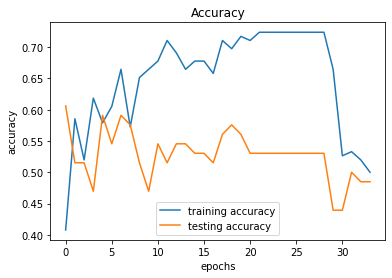

In [ ]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='testing accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

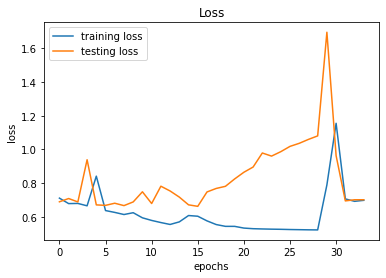

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='testing loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()